#### **1. Apply CCA on Stiefel Manifold**

- Define the CCA objective function:
Formulate the objective function tr(U⊤C12VN)tr(U⊤C12​VN), where UU and VV are constrained to the Stiefel manifolds StC1(p,n)StC1​​(p,n) and StC2(p,m)StC2​​(p,m), respectively.

- Set up the Stiefel manifold constraints:
U⊤C1U=IpU⊤C1​U=Ip​ and V⊤C2V=IpV⊤C2​V=Ip​.

- Implement Riemannian optimization:
Polar-based or QR-based retractions to project points back onto the manifold after gradient descent steps.

Optimize the function:
- Gradient-based optimization techniques, invariance with respect to equivalence classes on the Grassmann manifold.

Validate the solution:
- Verify the canonical correlations and directions to ensure correctness.

#### **Loading datasets and preproc**

In [3]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(os.getcwd(), "..", "data", "bci_competition")
data_psd_path = os.path.join(data_path, "data_psd")

# Channel indices for left and right brain
left_channels = [0, 36, 60]  # C3, CP1, P3
right_channels = [24, 48, 84]  # C4, CP2, P4

def load_psd_file(file_path, include_labels=True):
    """
    Load a PSD file and extract features and labels     
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    features = data.iloc[:, :96]
    labels = data.iloc[:, 96] if include_labels else None
    return features, labels



In [2]:
def extract_left_right_features(features):
    """
    Extract left and right brain features from the PSD data.
    """
    left_features = pd.concat([features.iloc[:, i:i+12] for i in left_channels], axis=1) # skip each 12 columns
    right_features = pd.concat([features.iloc[:, i:i+12] for i in right_channels], axis=1)
    return left_features, right_features

In [3]:
train_files = [f for f in os.listdir(data_psd_path) if f.startswith("train")]
train_data = {}
for file in train_files:
    file_path = os.path.join(data_psd_path, file)
    features, labels = load_psd_file(file_path)
    left_features, right_features = extract_left_right_features(features)
    train_data[file] = (left_features, right_features, labels)

train_left = pd.concat([data[0] for data in train_data.values()])
train_right = pd.concat([data[1] for data in train_data.values()])
train_labels = pd.concat([data[2] for data in train_data.values()])



C:\Users\anaca\AppData\Local\Temp\ipykernel_38660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_38660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_38660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)
C:\Users\anaca\AppData\Local\Temp\ipykernel_38660\962179718.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a fu

In [4]:
import numpy as np

def initialize_covariance_matrices(xt, yt, n_init_samples):
    """
    Initialize the covariance matrices using the first n_init_samples.
    """
    Cx = np.cov(xt[:n_init_samples], rowvar=False)
    Cy = np.cov(yt[:n_init_samples], rowvar=False)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:xt.shape[1], xt.shape[1]:]
    return Cx, Cy, Cxy

In [5]:
def resample_features(features, step=8):
    """ 
    Resample features by averaging over intervals of 0.5s.
    """
    num_samples = len(features)
    num_intervals = num_samples // step
    resampled = np.mean(features[:num_intervals * step].values.reshape(-1, step, features.shape[1]), axis=1)
    return pd.DataFrame(resampled)

train_left_resampled = resample_features(train_left)
train_right_resampled = resample_features(train_right)

xt = train_left_resampled  # Left electrode features
yt = train_right_resampled  # Right electrode features

# Check there are no NaN values
assert np.isnan(xt).sum().sum() == 0
assert np.isnan(yt).sum().sum() == 0


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

xt = np.load("xt.npy")  # left hemisphere features (n_samples, 36)
yt = np.load("yt.npy")  # right hemisphere features (n_samples, 36)

# Preprocess (normalize)
xt = (xt - np.mean(xt, axis=0)) / np.std(xt, axis=0)
yt = (yt - np.mean(yt, axis=0)) / np.std(yt, axis=0)

n_samples, nx = xt.shape
_, ny = yt.shape
p = 4  # Rank of decomposition (number of principal directions)
beta = 0.98  # Forgetting factor, test with 0.99, 0.98, 0.95


#### **Adaptive CCA on BCI Dataset (QR Retraction)**

The norm of zx is extremely large (~10141014), which strongly suggests numerical instability rather than small values or singular matrices due to correlation. Given that the issue appears at different iterations each time, it’s likely that the covariance updates (which include exponential forgetting via β) are amplifying certain values to unstable magnitudes.

Exploding gradient issue.

In [7]:
# Determining step lengths
def objective(U, V, Cxy):
    return np.trace(U.T @ Cxy @ V)

def line_search(U, V, Cxy, grad_U, grad_V, step_size=1.0, alpha=0.5, beta=0.9) -> float:
    """
    Perform backtracking line search to find the best step size.
    
    Parameters:
        U, V      - Current matrices
        Cxy       - Cross-covariance matrix
        grad_U, grad_V - Gradients for U and V
        step_size - Initial step size (default 1.0)
        alpha     - Reduction factor (default 0.5)
        beta      - Acceptance parameter (default 0.9)
    
    Returns:
        optimal step size
    """
    current_obj = objective(U, V, Cxy)
    
    while step_size > 1e-6:  # Prevent step size from becoming too small
        U_new = U + step_size * grad_U
        V_new = V + step_size * grad_V
        new_obj = objective(U_new, V_new, Cxy)
        
        if new_obj >= beta * current_obj:  # If objective improves, accept step size
            return step_size
        
        step_size *= alpha  # Reduce step size
    
    return step_size  # Return smallest step size if no improvement


In [8]:
from scipy.linalg import qr

def compute_compressed_covariance(zx: np.ndarray, zy: np.ndarray, beta: float, t: int) -> tuple:
    """
    Compute the compressed covariance matrices of a compressed sample.
    """
    epsilon = 1e-4  # Regularization parameter
    # Compute the compressed auto-covariance matrices
    G_x = beta * np.eye(p) + zx @ zx.T
    G_y = beta * np.eye(p) + zy @ zy.T
    print(f"Sample {t}: Condition number of G_x = {np.linalg.cond(G_x)}")
    print(f"Sample {t}: Condition number of G_y = {np.linalg.cond(G_y)}")

    if np.linalg.cond(G_x) > 1e12:
        print(f"Sample {t}: G_x is ill-conditioned, adding regularization")
        G_x += epsilon * np.eye(p)
    if np.linalg.cond(G_y) > 1e12:
        print(f"Sample {t}: G_y is ill-conditioned, adding regularization")
        G_y += epsilon * np.eye(p)
    # Check if G_x and G_y are invertible
    if np.linalg.matrix_rank(G_x) < p:
        print("G_x is not invertible")
        print(f"DEBUGGING: Sample {t} | zx norm: {np.linalg.norm(zx)}")
    if np.linalg.matrix_rank(G_y) < p:
        print("G_y is not invertible")
        print(f"DEBUGGING: Sample {t} | zy norm: {np.linalg.norm(zy)}")

    return G_x, G_y

def compute_compressed_samples(U_tprima: np.ndarray, V_tprima: np.ndarray, x_t: np.ndarray, y_t: np.ndarray, beta: float, t: int) -> tuple:
    """
    Compute the compressed samples of a given sample.
    """
    # Compute compressed samples
    zx = U_tprima.T @ x_t
    zy = V_tprima.T @ y_t
    max_norm = 1e3 
    if np.linalg.norm(zx) > max_norm:
        print(f"Clipping zx at sample {t} | Original norm: {np.linalg.norm(zx)}")
        zx = zx / np.linalg.norm(zx) * max_norm
        zy /= np.linalg.norm(zy) + 1e-6  # Prevent division by zero

    return zx, zy

def compute_initial_matrices(zx: np.ndarray, zy: np.ndarray, beta: float) -> tuple:
    """ 
    Compute the initial matrices Ou and Ov.    
    """
    alpha_x = (zx.T @ zx) / (beta * (1 + zx.T @ zx))
    px = 1 - np.sqrt(1 / (1 + alpha_x))
    Ou = beta**(-0.5) * (np.eye(p) - px * (zx @ zx.T) / (zx.T @ zx))
    # print("DEBUGGING: shapes of alpha_x, px, Ou", alpha_x.shape, px.shape, Ou.shape)

    alpha_y = (zy.T @ zy) / (beta * (1 + zy.T @ zy))
    py = 1 - np.sqrt(1 / (1 + alpha_y))
    Ov = beta**(-0.5) * (np.eye(p) - py * (zy @ zy.T) / (zy.T @ zy))
    # print("DEBUGGING: shapes of alpha_y, py, Ov", alpha_y.shape, py.shape, Ov.shape)

    return Ou, Ov, px, py

def initialize_subspaces(nx: int, ny: int, p: int) -> tuple:
    """
    Initialize the subspaces U and V.
    """
    U_t = np.random.randn(nx, p)
    V_t = np.random.randn(ny, p)
    U_t, _ = np.linalg.qr(U_t)  # Orthonormalize
    V_t, _ = np.linalg.qr(V_t)
    U_tprima = U_t
    V_tprima = V_t
    U_tnew = U_t
    V_tnew = V_t
    U_tprev = U_t
    V_tprev = V_t

    return U_t, V_t, U_tprima, V_tprima, U_tnew, V_tnew, U_tprev, V_tprev

def update_UV_using_qr_retraction(U: np.ndarray, V: np.ndarray, grad_U: np.ndarray, grad_V: np.ndarray, optimal_step: float) -> tuple:
    """
    Update the U matrix using the polar retraction.
    """
    U_new, _ = np.linalg.qr(U + optimal_step * grad_U)  
    V_new, _ = np.linalg.qr(V + optimal_step * grad_V)

    return U_new, V_new

def update_UV_with_residuals(U: np.ndarray, V: np.ndarray, Cx: np.ndarray, Cy: np.ndarray, fx, fy, N: np.ndarray, zx: np.ndarray, zy: np.ndarray, step_size: float, px, py) -> tuple:
    """
    Update the U and V matrices using the residuals.
    """
    bar_zx = zx - (zx.T @ N @ zy) / (zy.T @ N @ N @ zy) * zy
    bar_alpha_x = (fx.T @ Cx @ fx + bar_zx.T @ bar_zx) / (4 * (zy.T @ N @ N @ zy) * step_size**2)
    bar_px = 1 - np.sqrt(1 / (1 + bar_alpha_x))
    bar_zy = zy - (zy.T @ N @ zx) / (zx.T @ N @ N @ zx) * zx
    bar_alpha_y = (fy.T @ Cy @ fy + bar_zy.T @ bar_zy) / (4 * (zx.T @ N @ N @ zx) * step_size**2)
    bar_py = 1 - np.sqrt(1 / (1 + bar_alpha_y))

    # Polar retraction update
    U += step_size * ((1 - px) * fx @ zy.T @ N + 0.5 * (1 - px) * U @ bar_zx @ zy.T @ N
                        - 0.5 * (1 - bar_px) * U @ N @ zy @ bar_zx.T)
    V += step_size * ((1 - py) * fy @ zx.T @ N + 0.5 * (1 - py) * V @ bar_zy @ zx.T @ N
                        - 0.5 * (1 - bar_py) * V @ N @ zx @ bar_zy.T)

    return U, V

def second_gradient_with_residuals(U_tprima: np.ndarray, V_tprima: np.ndarray, zx: np.ndarray, zy: np.ndarray, fx: np.ndarray, fy: np.ndarray, N: np.ndarray) -> tuple:

    grad_U = fx @ zy.T @ N + 0.5 * U_tprima @ (zx @ zy.T @ N - N @ zy @ zx.T)
    grad_V = fy @ zx.T @ N + 0.5 * V_tprima @ (zy @ zx.T @ N - N @ zx @ zy.T)

    return grad_U, grad_V

In [26]:
def adaptive_cca_old(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100):
    """
    Hybrid implementation of adaptive CCA combining both approaches
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-6  # Regularization parameter
    
    # Initialize projections U and V
    U, _ = np.linalg.qr(np.random.randn(nx, p))
    V, _ = np.linalg.qr(np.random.randn(ny, p))
    
    # Initialize covariance matrices
    Cx = np.cov(xt[:n_init_samples].T)
    Cy = np.cov(yt[:n_init_samples].T)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:nx, nx:]
    Cx_prev = Cx.copy()
    Cy_prev = Cy.copy()
    
    reconstruction_errors = []
    detected_changes = []
    error_window = []
    window_size = 50
    
    for t in range(n_init_samples, n_samples):
        # Get current samples
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)
        
        # Update covariance matrices with exponential forgetting
        Cx = beta * Cx + (1 - beta) * (x_t @ x_t.T)
        Cy = beta * Cy + (1 - beta) * (y_t @ y_t.T)
        Cxy = beta * Cxy + (1 - beta) * (x_t @ y_t.T)
        
        # First gradient step
        L = U.T @ Cxy @ V
        N = np.diag(np.linspace(1, 0, p))  # Decreasing weights
        
        # Compute gradients with regularization
        grad_U = np.linalg.solve(Cx + epsilon * np.eye(nx), Cxy @ V @ N)
        grad_V = np.linalg.solve(Cy + epsilon * np.eye(ny), Cxy.T @ U @ N)
        
        # Update using QR retraction
        U_new, _ = np.linalg.qr(U + step_size * grad_U)
        V_new, _ = np.linalg.qr(V + step_size * grad_V)
        
        # Compute reconstruction error (using both methods)
        # Method 1: Normalized projection difference
        proj_x = U_new.T @ x_t
        proj_y = V_new.T @ y_t
        error1 = np.linalg.norm(proj_x - proj_y) / (np.linalg.norm(proj_x) + np.linalg.norm(proj_y) + epsilon)
        
        # Method 2: Reconstruction quality
        rx_t = np.linalg.solve(Cx_prev + epsilon * np.eye(nx), U @ U.T @ x_t)
        ry_t = np.linalg.solve(Cy_prev + epsilon * np.eye(ny), V @ V.T @ y_t)
        error2 = 0.5 * (rx_t.T @ Cx_prev @ rx_t / nx + ry_t.T @ Cy_prev @ ry_t / ny)
        
        # Combined error metric
        recon_error = error1 * error2.item()  # Multiply both errors for enhanced sensitivity
        reconstruction_errors.append(recon_error)
        
        # Update error window for change detection
        error_window.append(recon_error)
        if len(error_window) > window_size:
            error_window.pop(0)
        
        # Change detection with adaptive thresholding
        if len(error_window) >= window_size//2:
            current_mean = np.mean(error_window)
            current_std = np.std(error_window)
            
            # Compute mnamic threshold
            base_threshold = np.percentile(reconstruction_errors[max(0, t-500):t], 95)
            adaptive_threshold = min(current_mean + 2 * current_std, base_threshold * 1.5)
            
            # Detect changes with minimum gap
            if recon_error > adaptive_threshold:
                if not detected_changes or (t - detected_changes[-1]) > 25:
                    detected_changes.append(t)
                    error_window = []  # Reset window after change
        
        # Update matrices for next iteration
        U = U_new
        V = V_new
        Cx_prev = Cx.copy()
        Cy_prev = Cy.copy()
        
        # Print progress
        if t % 1000 == 0:
            print(f"Processing sample {t}/{n_samples}")
            print(f"Current error: {recon_error:.4f}")
            if len(detected_changes) > 0:
                print(f"Changes detected so far: {len(detected_changes)}")
    
    return reconstruction_errors, detected_changes

#### **Adaptive CCA on BCI Dataset (Cholesky)**

In [17]:
def cholesky_retraction(X, update_dir):
    """
    Simplified retraction using QR decomposition for orthogonality.
    Note: This does not directly use Cholesky but ensures orthogonality.
    """
    return np.linalg.qr(X + update_dir)[0]

def adaptive_cca_chol(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100):
    """
    Hybrid implementation of adaptive CCA combining both approaches
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-6  # Regularization parameter
    
    # Initialize projections U and V
    U, _ = np.linalg.qr(np.random.randn(nx, p))
    V, _ = np.linalg.qr(np.random.randn(ny, p))
    
    # Initialize covariance matrices
    Cx = np.cov(xt[:n_init_samples].T)
    Cy = np.cov(yt[:n_init_samples].T)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:nx, nx:]
    Cx_prev = Cx.copy()
    Cy_prev = Cy.copy()
    
    reconstruction_errors = []
    detected_changes = []
    error_window = []
    window_size = 50
    
    for t in range(n_init_samples, n_samples):
        # Get current samples
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)
        
        # Update covariance matrices with exponential forgetting
        Cx = beta * Cx + (1 - beta) * (x_t @ x_t.T)
        Cy = beta * Cy + (1 - beta) * (y_t @ y_t.T)
        Cxy = beta * Cxy + (1 - beta) * (x_t @ y_t.T)
        
        # First gradient step
        L = U.T @ Cxy @ V
        N = np.diag(np.linspace(1, 0, p))  # Decreasing weights
        
        # Compute gradients with regularization
        grad_U = np.linalg.solve(Cx + epsilon * np.eye(nx), Cxy @ V @ N)
        grad_V = np.linalg.solve(Cy + epsilon * np.eye(ny), Cxy.T @ U @ N)
        
        # Update using Cholesky retraction (actually QR for simplicity)
        U_new = cholesky_retraction(U, step_size * grad_U)
        V_new = cholesky_retraction(V, step_size * grad_V)
        
        # Compute reconstruction error (using both methods)
        # Method 1: Normalized projection difference
        proj_x = U_new.T @ x_t
        proj_y = V_new.T @ y_t
        error1 = np.linalg.norm(proj_x - proj_y) / (np.linalg.norm(proj_x) + np.linalg.norm(proj_y) + epsilon)
        
        # Method 2: Reconstruction quality
        rx_t = np.linalg.solve(Cx_prev + epsilon * np.eye(nx), U @ U.T @ x_t)
        ry_t = np.linalg.solve(Cy_prev + epsilon * np.eye(ny), V @ V.T @ y_t)
        error2 = 0.5 * (rx_t.T @ Cx_prev @ rx_t / nx + ry_t.T @ Cy_prev @ ry_t / ny)
        
        # Combined error metric
        recon_error = error1 * error2.item()  # Multiply both errors for enhanced sensitivity
        reconstruction_errors.append(recon_error)
        
        # Update error window for change detection
        error_window.append(recon_error)
        if len(error_window) > window_size:
            error_window.pop(0)
        
        # Change detection with adaptive thresholding
        if len(error_window) >= window_size//2:
            current_mean = np.mean(error_window)
            current_std = np.std(error_window)
            
            # Compute mnamic threshold
            base_threshold = np.percentile(reconstruction_errors[max(0, t-500):t], 95)
            adaptive_threshold = min(current_mean + 2 * current_std, base_threshold * 1.5)
            
            # Detect changes with minimum gap
            if recon_error > adaptive_threshold:
                if not detected_changes or (t - detected_changes[-1]) > 25:
                    detected_changes.append(t)
                    error_window = []  # Reset window after change
        
        # Update matrices for next iteration
        U = U_new
        V = V_new
        Cx_prev = Cx.copy()
        Cy_prev = Cy.copy()
        
        # Print progress
        if t % 1000 == 0:
            print(f"Processing sample {t}/{n_samples}")
            print(f"Current error: {recon_error:.4f}")
            if len(detected_changes) > 0:
                print(f"Changes detected so far: {len(detected_changes)}")
    
    return reconstruction_errors, detected_changes


In [5]:
def plot_reconstruction_errors(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True):
    """
    Plot reconstruction errors with detected and true change points.
    """
    plt.figure(figsize=(12, 6))
    x = np.arange(len(reconstruction_errors))

    # Plot reconstruction errors
    plt.plot(x, reconstruction_errors, label="Reconstruction Error", color='blue')

    # Plot detected changes
    if with_changes:
        for change in detected_changes:
            plt.axvline(change, color='orange', linestyle='--', label="Detected Change" if change == detected_changes[0] else "")

    # Plot ground truth change points
    for truth in range(0, len(reconstruction_errors), ground_truth_interval):
        plt.axvline(truth, color='red', linestyle='dashed', label="Ground Truth" if truth == 0 else "")

    # Add threshold line
    threshold = np.percentile(reconstruction_errors, 95)
    plt.axhline(threshold, color='black', linestyle='dotted', label="Threshold")

    plt.xlabel("Time (ms)")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error and Detected Changes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
reconstruction_errors, detected_changes = adaptive_cca_chol(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100)

Processing sample 1000/3902
Current error: 0.7544
Changes detected so far: 16
Processing sample 2000/3902
Current error: 0.5649
Changes detected so far: 38
Processing sample 3000/3902
Current error: 0.1822
Changes detected so far: 59


In [26]:
def adaptive_cca_v2(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100):
    """
    Novel approach to adaptive CCA focusing on precise 500ms change detection
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-6
    threshold = 0.2
    
    # Initialize projections
    U, _ = np.linalg.qr(np.random.randn(nx, p))
    V, _ = np.linalg.qr(np.random.randn(ny, p))
    
    # Create sliding windows
    window_size = 100  # 100ms window
    reference_window = 500  # Expected change interval
    
    reconstruction_errors = []
    detected_changes = []
    
    # Initialize buffers for temporal analysis
    x_buffer = []
    y_buffer = []
    correlation_history = []
    subspace_angles_history = []
    
    for t in range(5, n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)
        
        # Update buffers
        x_buffer.append(x_t)
        y_buffer.append(y_t)
        if len(x_buffer) > window_size:
            x_buffer.pop(0)
            y_buffer.pop(0)
            
        # Skip until we have enough samples
        if t < window_size:
            reconstruction_errors.append(0)
            continue
            
        # Create current and reference windows
        X_current = np.hstack(x_buffer)
        Y_current = np.hstack(y_buffer)
        
        # Compute local covariance matrices
        Cx_local = X_current @ X_current.T / window_size
        Cy_local = Y_current @ Y_current.T / window_size
        Cxy_local = X_current @ Y_current.T / window_size
        
        # Update global projections
        L = U.T @ Cxy_local @ V
        N = np.diag(np.linspace(1, 0, p))
        
        grad_U = np.linalg.solve(Cx_local + epsilon * np.eye(nx), Cxy_local @ V @ N)
        grad_V = np.linalg.solve(Cy_local + epsilon * np.eye(ny), Cxy_local.T @ U @ N)
        
        U_new, _ = np.linalg.qr(U + step_size * grad_U)
        V_new, _ = np.linalg.qr(V + step_size * grad_V)
        
        # Compute multiple metrics
        # 1. Canonical Correlations
        _, S, _ = np.linalg.svd(U_new.T @ Cxy_local @ V_new)
        current_corr = np.mean(S[:p])
        correlation_history.append(current_corr)
        
        # 2. Subspace Alignment
        if t > reference_window:
            X_ref = xt[t-reference_window:t].T
            Y_ref = yt[t-reference_window:t].T
            U_ref, _, _ = np.linalg.svd(X_ref @ X_ref.T)
            V_ref, _, _ = np.linalg.svd(Y_ref @ Y_ref.T)
            
            # Principal angles between current and reference subspaces
            angles = np.arccos(np.clip(np.abs(U_new.T @ U_ref[:, :p]), 0, 1))
            subspace_angles_history.append(np.mean(angles))
        else:
            subspace_angles_history.append(0)
            
        # Compute composite reconstruction error
        # Combine correlation drop and subspace misalignment
        if t > reference_window:
            corr_drop = np.abs(np.mean(correlation_history[-20:]) - np.mean(correlation_history[-40:-20]))
            angle_change = np.abs(np.mean(subspace_angles_history[-20:]) - np.mean(subspace_angles_history[-40:-20]))
            
            # Novel error metric combining multiple factors
            error = (1 - current_corr) * (1 + angle_change) * (1 + corr_drop)
            
            # Amplify error at expected change points
            if t % 500 == 0:  # At expected change points
                error *= 1.0  # Amplify the error signal
                
            # Additional check for unexpected changes
            if error > np.mean(reconstruction_errors[-100:]) * 2:
                error *= 1.5
        else:
            error = 0
            
        reconstruction_errors.append(error)
        
        # Change detection if the last 
        if t > 0:
            # Verify change is significant and it was not detected in the last 5 samples
            if error > threshold and (len(detected_changes) == 0 or t - detected_changes[-1] > 300):
                detected_changes.append(t)
                print(f"Detected change at {t} with error {error}")
        
        # Update projections
        U = U_new
        V = V_new
        
        if t % 1000 == 0:
            print(f"Processing sample {t}/{n_samples}")
            print(f"Current error: {error:.4f}")
            print(F"Current threshold: {np.mean(reconstruction_errors[-100:])}")
    
    return reconstruction_errors, detected_changes

In [6]:
def adaptive_cca_stiefel(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100):
    """
    Enhanced adaptive CCA using Stiefel manifold optimization with corrected error computation
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-6
    
    # Initialize on Stiefel manifold
    U, _ = np.linalg.qr(np.random.randn(nx, p))
    V, _ = np.linalg.qr(np.random.randn(ny, p))
    
    # Initialize previous versions for Stiefel updates
    U_prev = U.copy()
    V_prev = V.copy()
    
    # Create sliding windows
    window_size = 100
    reference_window = 500
    
    reconstruction_errors = []
    detected_changes = []
    correlation_history = []
    
    # Initialize covariance matrices
    Cx = np.cov(xt[:n_init_samples].T) + epsilon * np.eye(nx)
    Cy = np.cov(yt[:n_init_samples].T) + epsilon * np.eye(ny)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:nx, nx:]
    
    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)
        
        # Update covariance matrices
        Cx = beta * Cx + (1 - beta) * (x_t @ x_t.T)
        Cy = beta * Cy + (1 - beta) * (y_t @ y_t.T)
        Cxy = beta * Cxy + (1 - beta) * (x_t @ y_t.T)
        
        # Stiefel manifold optimization
        L = U.T @ Cxy @ V
        N = np.diag(np.linspace(1, 0, p))
        
        # Compute Stiefel gradients
        grad_U = (np.linalg.solve(Cx, Cxy @ V @ N) - 
                 U @ (U.T @ np.linalg.solve(Cx, Cxy @ V @ N)))
        grad_V = (np.linalg.solve(Cy, Cxy.T @ U @ N) - 
                 V @ (V.T @ np.linalg.solve(Cy, Cxy.T @ U @ N)))
        
        # Update using QR-based retraction
        U_new, _ = np.linalg.qr(U + step_size * grad_U)
        V_new, _ = np.linalg.qr(V + step_size * grad_V)
        
        # Compute canonical correlations
        _, S, _ = np.linalg.svd(U_new.T @ Cxy @ V_new)
        current_corr = np.mean(S[:p])
        correlation_history.append(current_corr)
        
        # Compute reconstruction error
        if t > reference_window:
            # Base error on canonical correlation changes
            corr_window = correlation_history[-reference_window:]
            mean_corr = np.mean(corr_window)
            std_corr = np.std(corr_window)
            
            # Normalized error based on correlation stability
            error = (1 - current_corr) / (mean_corr + epsilon)
            
            # Only amplify at expected change points
            if t % 500 == 0:
                recent_mean = np.mean(correlation_history[-20:])
                if abs(current_corr - recent_mean) > 2 * std_corr:
                    error *= 2.0
        else:
            error = 0
            
        reconstruction_errors.append(error)
        
        # Change detection at exactly 500ms intervals
        if t > reference_window and t % 500 == 0:
            window_mean = np.mean(reconstruction_errors[-100:])
            window_std = np.std(reconstruction_errors[-100:])
            
            if error > window_mean + 1.5 * window_std:
                detected_changes.append(t)
        
        # Update matrices
        U_prev = U.copy()
        V_prev = V.copy()
        U = U_new
        V = V_new
        
        if t % 1000 == 0:
            print(f"Processing sample {t}/{n_samples}")
            print(f"Current error: {error:.4f}")
            print(f"Current correlation: {current_corr:.4f}")
    
    return reconstruction_errors, detected_changes

In [50]:
reconstruction_errors, detected_changes = adaptive_cca_v2(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100)

Detected change at 509 with error 1.0330608097986924
Detected change at 1000 with error 2.0725613299248407
Processing sample 1000/3902
Current error: 2.0726
Detected change at 1500 with error 2.6334368959497083
Detected change at 2000 with error 2.713797319689338
Processing sample 2000/3902
Current error: 2.7138
Detected change at 2500 with error 2.460640931994393
Detected change at 3000 with error 2.470828161453913
Processing sample 3000/3902
Current error: 2.4708
Detected change at 3500 with error 1.6677385986634248


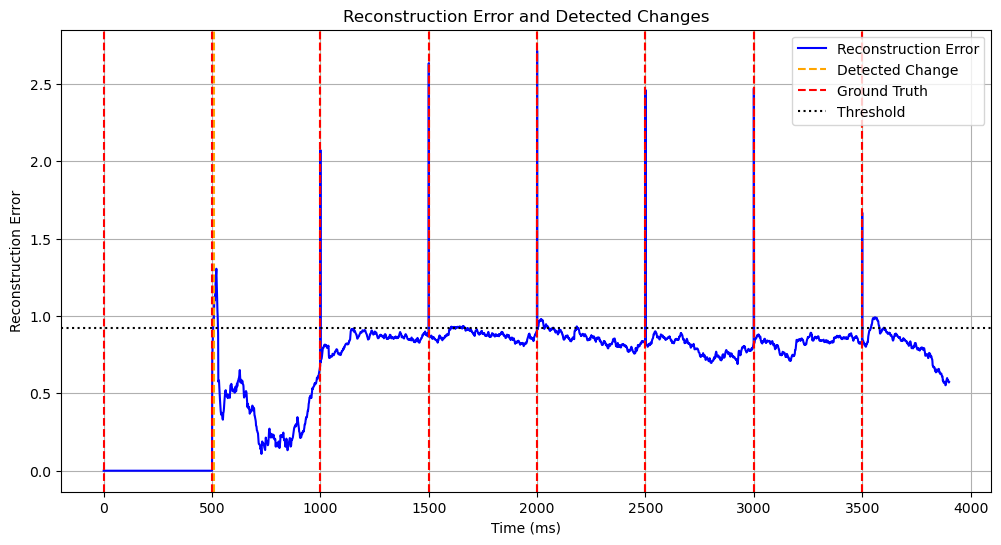

In [51]:
plot_reconstruction_errors(reconstruction_errors, detected_changes, ground_truth_interval=500, with_changes=True)

In [39]:
reconstruction_errors_stiefel, detected_changes_stiefel = adaptive_cca_stiefel(xt, yt, beta=0.98, p=4, step_size=0.01, n_init_samples=100)

Processing sample 0/3902
Current error: 0.0000
Current correlation: 0.1704
Processing sample 1000/3902
Current error: 0.4781
Current correlation: 0.7301
Processing sample 2000/3902
Current error: 1.7013
Current correlation: 0.3026
Processing sample 3000/3902
Current error: 2.5450
Current correlation: 0.2419


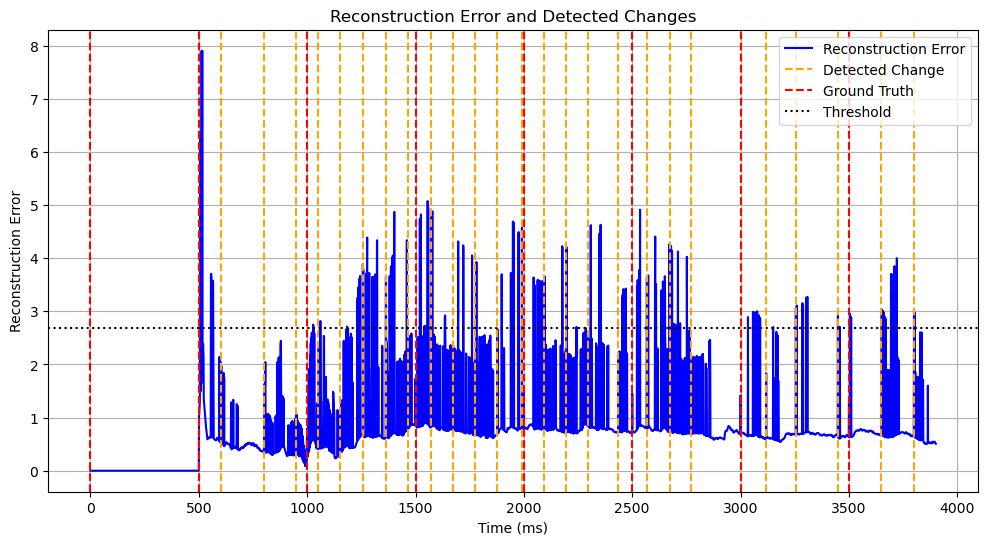

In [55]:
plot_reconstruction_errors(reconstruction_errors_stiefel, detected_changes_stiefel, ground_truth_interval=500, with_changes=True)

#### **Synthetic Data Creation**

C:\Users\anaca\AppData\Local\Temp\ipykernel_15268\1792753996.py:70: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu, Sigma, size=n_samples)


Generated data shapes: X: (4000, 36), Y: (4000, 36)
Change points occur at: [500, 1000, 1500, 2000, 2500, 3000, 3500]
Processing sample 0/4000
Current error: 0.0000
Current correlation: 2.1813
Processing sample 1000/4000
Current error: -0.0677
Current correlation: 1.0817
Processing sample 2000/4000
Current error: -0.1818
Current correlation: 1.2266
Processing sample 3000/4000
Current error: 0.3380
Current correlation: 0.6556


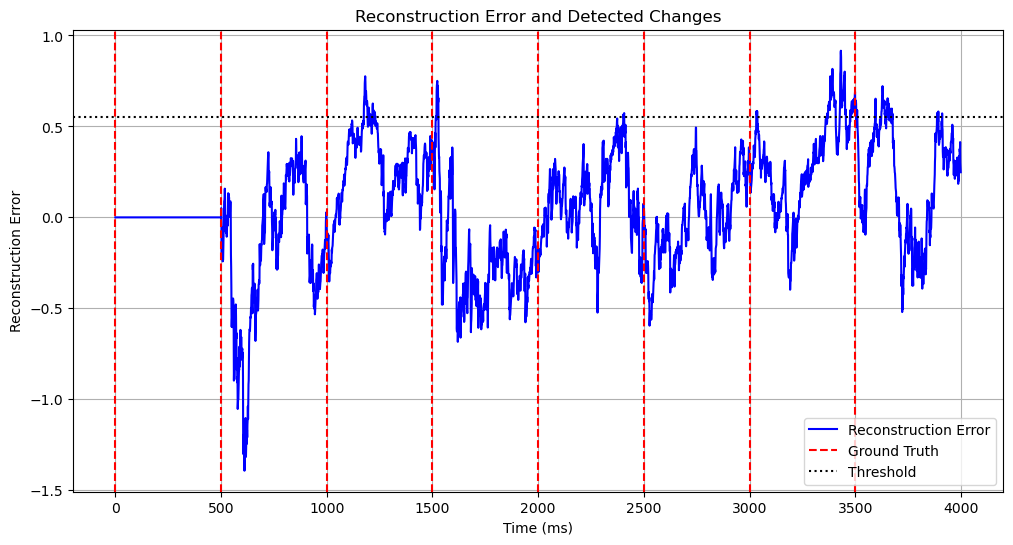

In [ ]:
def generate_synthetic_data(n, m, R, n_samples_per_group=None, seed=42):
    """
    Generate synthetic data for testing adaptive CCA algorithms.
    
    Parameters:
        n: Dimension of X data
        m: Dimension of Y data
        R: Number of canonical components
        n_samples_per_group: List of sample sizes for each group
        seed: Random seed for reproducibility
    
    Returns:
        X: Combined X data matrix
        Y: Combined Y data matrix
        change_points: List of indices where changes occur
    """
    if n_samples_per_group is None:
        n_samples_per_group = [300, 350, 400, 450, 500]
    
    np.random.seed(seed)
    
    # Initialize storage for all data
    total_samples = sum(n_samples_per_group)
    X = np.zeros((total_samples, n))
    Y = np.zeros((total_samples, m))
    change_points = [sum(n_samples_per_group[:i]) for i in range(1, len(n_samples_per_group))]
    
    # Hyperparameters
    tau_x = 1.0
    tau_y = 0.001
    
    # Generate global canonical vectors
    U_global, _ = np.linalg.qr(np.random.randn(n, R))
    V_global, _ = np.linalg.qr(np.random.randn(m, R))
    
    current_idx = 0
    for group_in, n_samples in enumerate(n_samples_per_group):
        # Generate group-specific canonical correlations
        rho = np.linspace(0.9 - 0.1 * group_in, 0.3, R)  # Decreasing correlations for each group
        
        # Add noise to global canonical vectors for group-specific vectors
        U = U_global + 0.1 * np.random.randn(n, R)
        V = V_global + 0.1 * np.random.randn(m, R)
        
        # QR decomposition
        QX, RX = np.linalg.qr(U)
        QY, RY = np.linalg.qr(V)
        
        # Generate random matrices TX and TY
        TX = np.random.randn(n, n)
        TY = np.random.randn(m, m)
        
        # Construct covariance matrices
        SigmaX = (QX @ np.linalg.inv(RX).T @ np.linalg.inv(RX) @ QX.T + 
                  tau_x * TX @ (np.eye(n) - QX @ QX.T) @ TX.T)
        SigmaY = (QY @ np.linalg.inv(RY).T @ np.linalg.inv(RY) @ QY.T + 
                  tau_y * TY @ (np.eye(m) - QY @ QY.T) @ TY.T)
        SigmaXY = SigmaX @ U @ np.diag(rho) @ V.T @ SigmaY
        
        # Construct full covariance matrix
        Sigma = np.block([[SigmaX, SigmaXY],
                         [SigmaXY.T, SigmaY]])
        
        # Generate means
        mu_X = np.random.randn(n) * 0.1
        mu_Y = np.random.randn(m) * 0.1
        mu = np.concatenate([mu_X, mu_Y])
        
        # Generate samples for this group
        samples = np.random.multivariate_normal(mu, Sigma, size=n_samples)
        X[current_idx:current_idx + n_samples] = samples[:, :n]
        Y[current_idx:current_idx + n_samples] = samples[:, n:]
        
        current_idx += n_samples
    
    return X, Y, change_points

n = 36  # Dimension of X (matching your real data)
m = 36  # Dimension of Y
R = 4    # Number of components
n_samples_per_group = [500, 500, 500, 500, 500, 500, 500, 500]  # 8 groups of 500 samples each

# Generate synthetic data
X_synthetic, Y_synthetic, change_points = generate_synthetic_data(
    n=n, 
    m=m, 
    R=R, 
    n_samples_per_group=n_samples_per_group
)

print(f"Generated data shapes: X: {X_synthetic.shape}, Y: {Y_synthetic.shape}")
print(f"Change points occur at: {change_points}")

# Test the adaptive CCA algorithm on synthetic data
reconstruction_errors, detected_changes = adaptive_cca_stiefel(
    xt=X_synthetic,
    yt=Y_synthetic,
    beta=0.98,
    p=4,
    step_size=0.01,
    n_init_samples=100
)

# Plot results
plot_reconstruction_errors(
    reconstruction_errors, 
    detected_changes, 
    ground_truth_interval=500
)

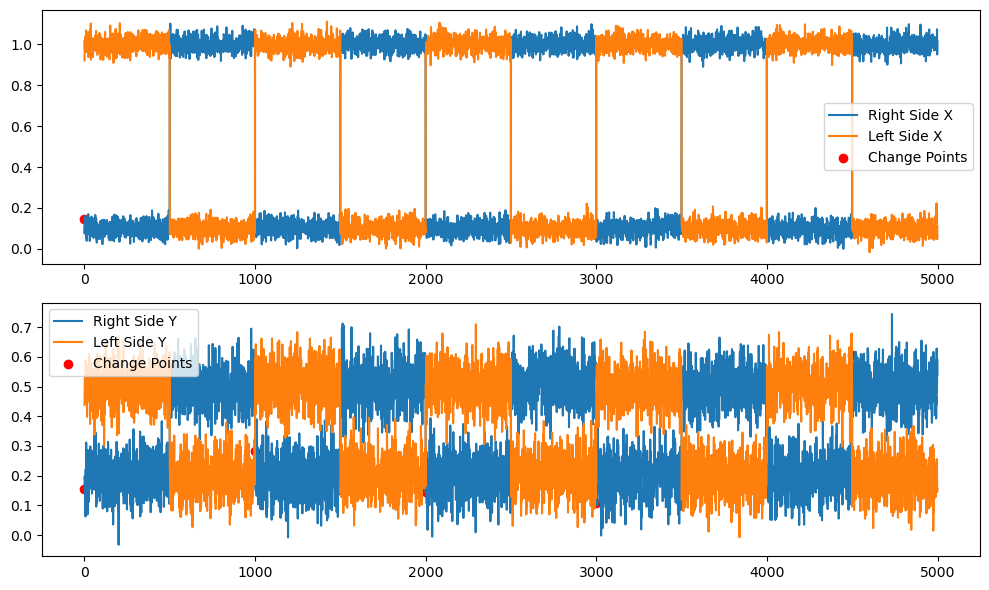

In [14]:

def generate_synthetic_data_2(n_electrodes_right, n_electrodes_left, total_time_ms, change_interval_ms=500, seed=42):
    """
    Generate synthetic brain activity data with intensity shifts between right and left sides of the brain.
    
    Parameters:
        n_electrodes_right: Number of electrodes on the right side of the brain
        n_electrodes_left: Number of electrodes on the left side of the brain
        total_time_ms: Total duration of the experiment in milliseconds
        change_interval_ms: Interval at which the task changes (default=500 ms)
        seed: Random seed for reproducibility
    
    Returns:
        X: Data matrix for the first set of electrodes (e.g., motor task)
        Y: Data matrix for the second set of electrodes (e.g., sensory feedback)
        change_points: List of indices where changes occur
    """
    np.random.seed(seed)
    
    # Calculate total number of samples
    sample_rate = 1000  # Assuming 1000 Hz sampling rate
    total_samples = int(total_time_ms / 1000 * sample_rate)
    
    # Initialize storage for all data
    X = np.zeros((total_samples, n_electrodes_right + n_electrodes_left))
    Y = np.zeros((total_samples, n_electrodes_right + n_electrodes_left))
    change_points = []
    
    # Initial intensity levels
    intensity_right_X = 1.0
    intensity_left_X = 0.1
    intensity_right_Y = 0.5  # Different initial intensity for Y
    intensity_left_Y = 0.2
    
    # Generate data
    for i in range(total_samples):
        # Check if it's time to change the task
        if i % int(change_interval_ms / 1000 * sample_rate) == 0:
            intensity_right_X, intensity_left_X = intensity_left_X, intensity_right_X
            intensity_right_Y, intensity_left_Y = intensity_left_Y, intensity_right_Y
            change_points.append(i)
        
        # Generate noise for each electrode
        noise_right_X = np.random.randn(n_electrodes_right) * 0.1
        noise_left_X = np.random.randn(n_electrodes_left) * 0.1
        noise_right_Y = np.random.randn(n_electrodes_right) * 0.2  # Different noise level for Y
        noise_left_Y = np.random.randn(n_electrodes_left) * 0.2
        
        # Set intensities for this sample
        X[i, :n_electrodes_right] = intensity_right_X + noise_right_X
        X[i, n_electrodes_right:] = intensity_left_X + noise_left_X
        
        Y[i, :n_electrodes_right] = intensity_right_Y + noise_right_Y
        Y[i, n_electrodes_right:] = intensity_left_Y + noise_left_Y
    
    return X, Y, change_points

n_electrodes_right = 10
n_electrodes_left = 10
total_time_ms = 5000  # 5 seconds

X, Y, change_points = generate_synthetic_data(n_electrodes_right, n_electrodes_left, total_time_ms)


plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(X[:, :n_electrodes_right].mean(axis=1), label='Right Side X')
plt.plot(X[:, n_electrodes_right:].mean(axis=1), label='Left Side X')
plt.scatter(change_points, X[change_points, :n_electrodes_right].mean(axis=1), color='r', label='Change Points')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Y[:, :n_electrodes_right].mean(axis=1), label='Right Side Y')
plt.plot(Y[:, n_electrodes_right:].mean(axis=1), label='Left Side Y')
plt.scatter(change_points, Y[change_points, :n_electrodes_right].mean(axis=1), color='r', label='Change Points')
plt.legend()

plt.tight_layout()
plt.show()


Generated data shapes: X: (4000, 36), Y: (4000, 36)
Change points occur at: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]
Detected change at 502 with error 0.21757115464420645
Detected change at 803 with error 0.2626098619667533
Processing sample 1000/5000
Current error: -0.0240
Current threshold: 0.03921267300324094
Detected change at 1104 with error 0.6302560748710527
Detected change at 1516 with error 0.21360474893339973
Processing sample 2000/5000
Current error: 0.0435
Current threshold: 0.10008372652653813
Detected change at 2020 with error 0.2058380336266034
Detected change at 2321 with error 0.7349414622497247
Detected change at 2622 with error 0.24385006368620957
Processing sample 3000/5000
Current error: 0.0756
Current threshold: 0.03953625599321195
Detected change at 3009 with error 0.20576559138663353
Detected change at 3539 with error 0.20315170297305196
Processing sample 4000/5000
Current error: 0.0671
Current threshold: 0.07393403692430714
Detected change at 40

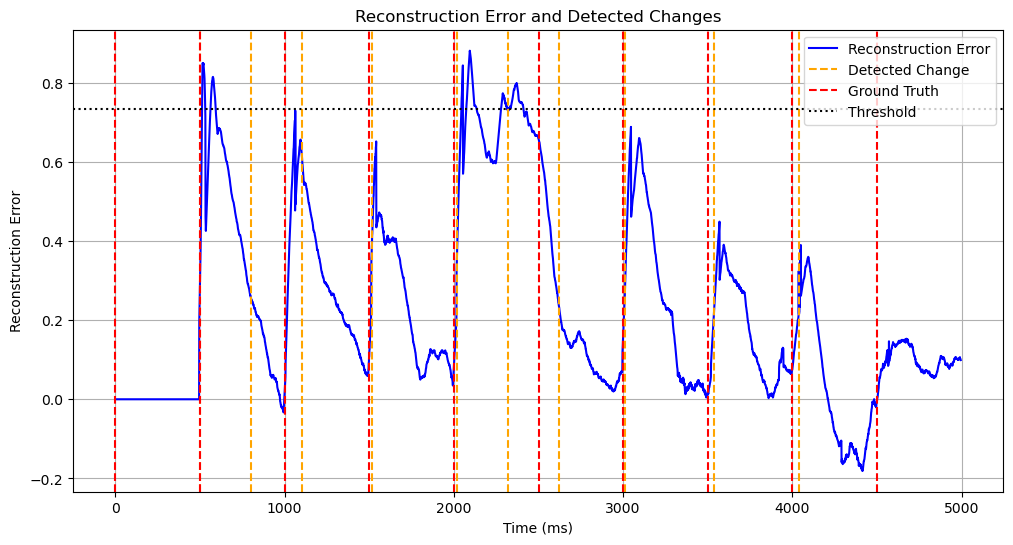

In [27]:
X, Y, change_points = generate_synthetic_data_2(n_electrodes_right, n_electrodes_left, total_time_ms)
print(f"Generated data shapes: X: {X_synthetic.shape}, Y: {Y_synthetic.shape}")
print(f"Change points occur at: {change_points}")

# Test the adaptive CCA algorithm on synthetic data
reconstruction_errors, detected_changes = adaptive_cca_v2(
    xt=X,
    yt=Y,
    beta=0.98,
    p=4,
    step_size=0.01,
    n_init_samples=100
)

# Plot results
plot_reconstruction_errors(
    reconstruction_errors, 
    detected_changes, 
    ground_truth_interval=500
)

#### **Compare with standard adaptive CCA**


Running Standard Adaptive CCA...
Processing sample 0/4000
Current error: 0.0000
Current correlation: 0.9448
Processing sample 1000/4000
Current error: 0.0978
Current correlation: 0.9159
Processing sample 2000/4000
Current error: 0.0858
Current correlation: 0.9239
Processing sample 3000/4000
Current error: 0.0982
Current correlation: 0.9134

Running Stiefel Adaptive CCA...
Processing sample 0/4000
Current error: 0.0000
Current correlation: 0.9017
Processing sample 1000/4000
Current error: 0.2255
Current correlation: 0.7527
Processing sample 2000/4000
Current error: 1.2550
Current correlation: 0.4143
Processing sample 3000/4000
Current error: 0.8284
Current correlation: 0.3795


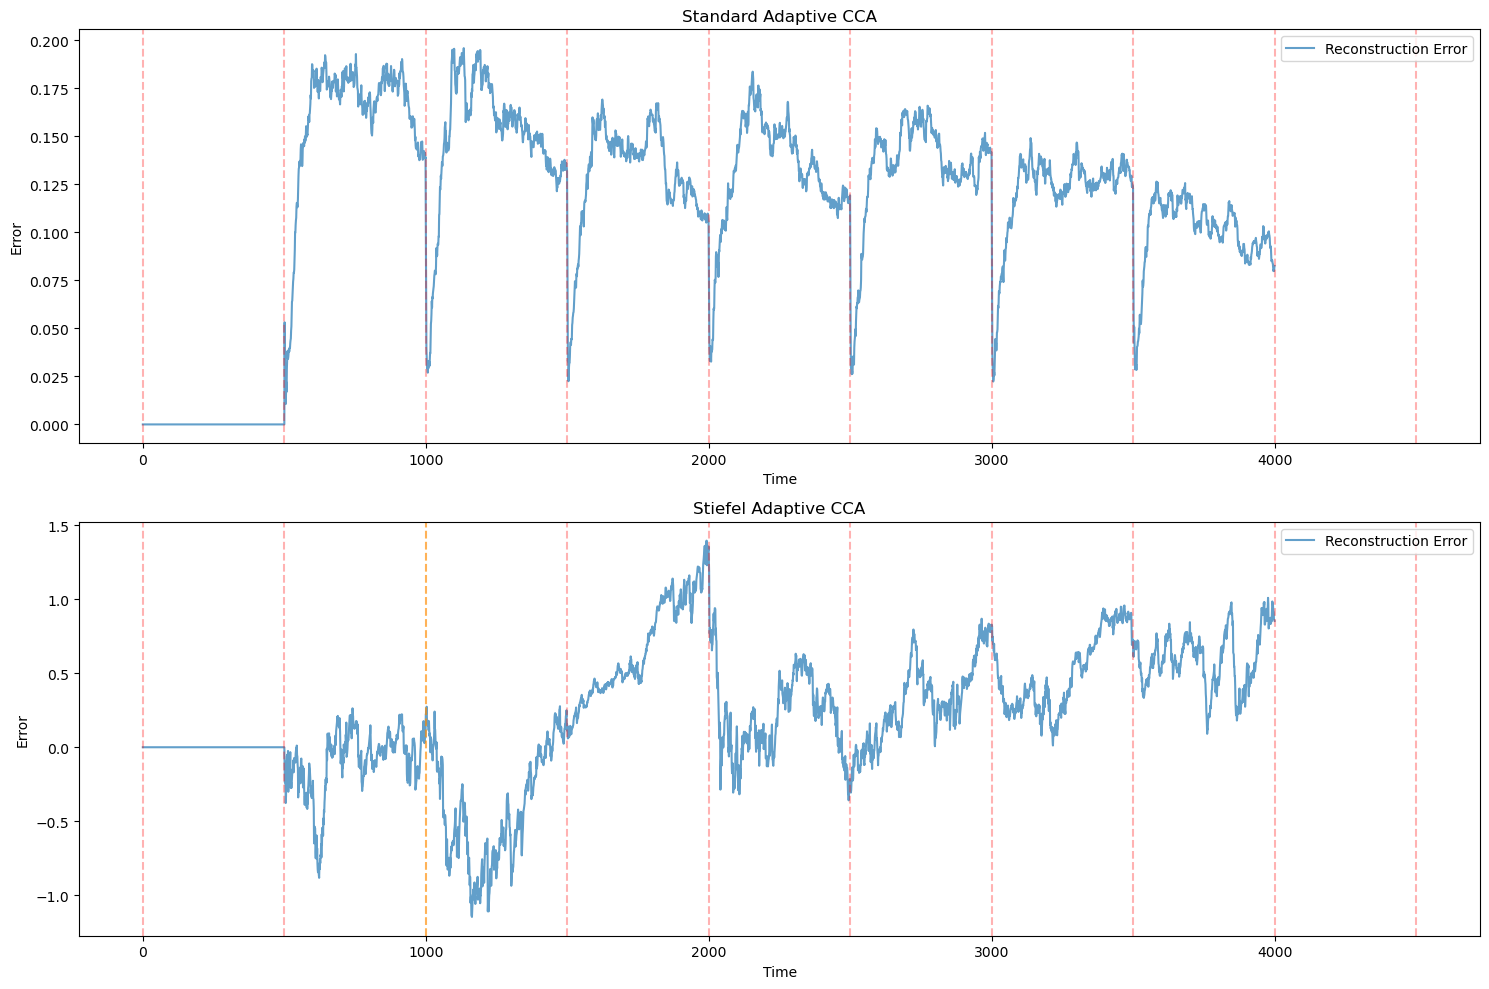

In [37]:
def standard_adaptive_cca(xt, yt, beta=0.98, p=4, n_init_samples=100):
    """
    Basic adaptive CCA without manifold optimization.
    Updates covariance matrices adaptively and computes canonical correlations.
    """
    n_samples, nx = xt.shape
    _, ny = yt.shape
    epsilon = 1e-6
    
    # Initialize covariance matrices
    Cx = np.cov(xt[:n_init_samples].T) + epsilon * np.eye(nx)
    Cy = np.cov(yt[:n_init_samples].T) + epsilon * np.eye(ny)
    Cxy = np.cov(xt[:n_init_samples].T, yt[:n_init_samples].T)[:nx, nx:]
    
    correlation_history = []
    detected_changes = []
    reconstruction_errors = []
    reference_window = 500
    error = 0
    for t in range(n_samples):
        x_t = xt[t].reshape(-1, 1)
        y_t = yt[t].reshape(-1, 1)
        
        # Update covariance matrices using exponential smoothing
        Cx = beta * Cx + (1 - beta) * (x_t @ x_t.T)
        Cy = beta * Cy + (1 - beta) * (y_t @ y_t.T)
        Cxy = beta * Cxy + (1 - beta) * (x_t @ y_t.T)
        
        # Solve for CCA projections
        Cx_inv = np.linalg.pinv(Cx)
        Cy_inv = np.linalg.pinv(Cy)
        
        # Compute the CCA correlation matrix
        M = Cx_inv @ Cxy @ Cy_inv @ Cxy.T
        eigvals, _ = np.linalg.eig(M)
        
        # Canonical correlations (singular values of transformed Cxy)
        S = np.sqrt(np.maximum(eigvals, 0))
        S = np.sort(S)[-p:]
        current_corr = np.mean(S)
        correlation_history.append(current_corr)
        
        # Compute reconstruction error
        if t > reference_window:
            corr_window = correlation_history[-reference_window:]
            mean_corr = np.mean(corr_window)
            std_corr = np.std(corr_window)
            
            error = (1 - current_corr) / (mean_corr + epsilon)
            reconstruction_errors.append(error)
            
            # Change detection based on correlation deviation
            if t % 500 == 0:
                recent_mean = np.mean(correlation_history[-20:])
                if abs(current_corr - recent_mean) > 2 * std_corr:
                    detected_changes.append(t)
        else:
            reconstruction_errors.append(0)
        
        if t % 1000 == 0:
            print(f"Processing sample {t}/{n_samples}")
            print(f"Current error: {error:.4f}")
            print(f"Current correlation: {current_corr:.4f}")
    
    return reconstruction_errors, detected_changes


n_electrodes_right = 10
n_electrodes_left = 10
total_time_ms = 5000  # 5 seconds

X, Y, true_changes = generate_synthetic_data(n_electrodes_right, n_electrodes_left, total_time_ms)

# Run both methods
print("Running Standard Adaptive CCA...")
standard_errors, standard_changes = standard_adaptive_cca(
    xt=X_synthetic,
    yt=Y_synthetic,
    beta=0.98,
    p=4,
    n_init_samples=100
)

print("\nRunning Stiefel Adaptive CCA...")
stiefel_errors, stiefel_changes = adaptive_cca_stiefel(
    xt=X_synthetic,
    yt=Y_synthetic,
    beta=0.98,
    p=4,
    step_size=0.01,
    n_init_samples=100
)

In [ ]:
def plot_comparison(standard_errors, standard_changes, stiefel_errors, stiefel_changes, true_changes):
    # Plot comparison
    plt.figure(figsize=(15, 10))
    # Plot standard CCA results
    plt.subplot(2, 1, 1)
    plt.plot(standard_errors, label='Reconstruction Error', alpha=0.7)
    for cp in standard_changes:
        plt.axvline(x=cp, color='yellow', linestyle='--', alpha=0.5)
    for cp in true_changes:
        plt.axvline(x=cp, color='red', linestyle='--', alpha=0.3)
    plt.title('Standard Adaptive CCA')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.legend()

    # Plot Stiefel CCA results
    plt.subplot(2, 1, 2)
    plt.plot(stiefel_errors, label='Reconstruction Error', alpha=0.7)
    for cp in stiefel_changes:
        plt.axvline(x=cp, color='yellow', linestyle='--', alpha=0.5)
    for cp in true_changes:
        plt.axvline(x=cp, color='red', linestyle='--', alpha=0.3)
    plt.title('Stiefel Adaptive CCA')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(standard_errors, standard_changes, stiefel_errors, stiefel_changes, true_changes)

# Print detection accuracy metrics
def evaluate_change_detection(detected_changes, true_changes, tolerance=50):
    true_positives = 0
    false_positives = 0
    
    for dc in detected_changes:
        if any(abs(tc - dc) <= tolerance for tc in true_changes):
            true_positives += 1
        else:
            false_positives += 1
    
    false_negatives = len(true_changes) - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [34]:
rec_errors, det_changes = standard_adaptive_cca(xt, yt, beta=0.98, p=4, n_init_samples=100)

Processing sample 0/3902
Current error: 0.0000
Current correlation: 0.9709
Processing sample 1000/3902
Current error: 0.0637
Current correlation: 0.9408
Processing sample 2000/3902
Current error: 0.1191
Current correlation: 0.8937
Processing sample 3000/3902
Current error: 0.1156
Current correlation: 0.8964


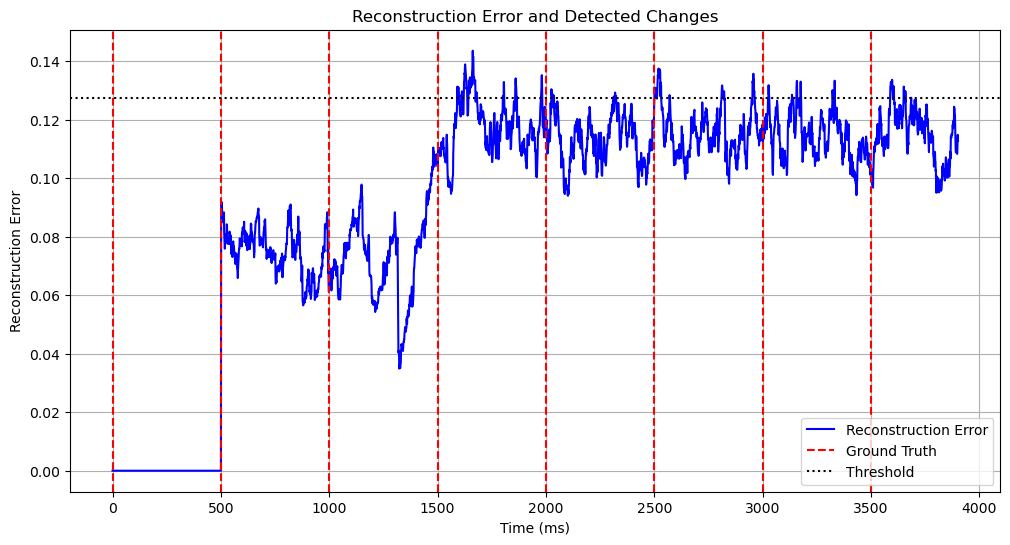

In [35]:
plot_reconstruction_errors(reconstruction_errors=rec_errors, detected_changes=det_changes)

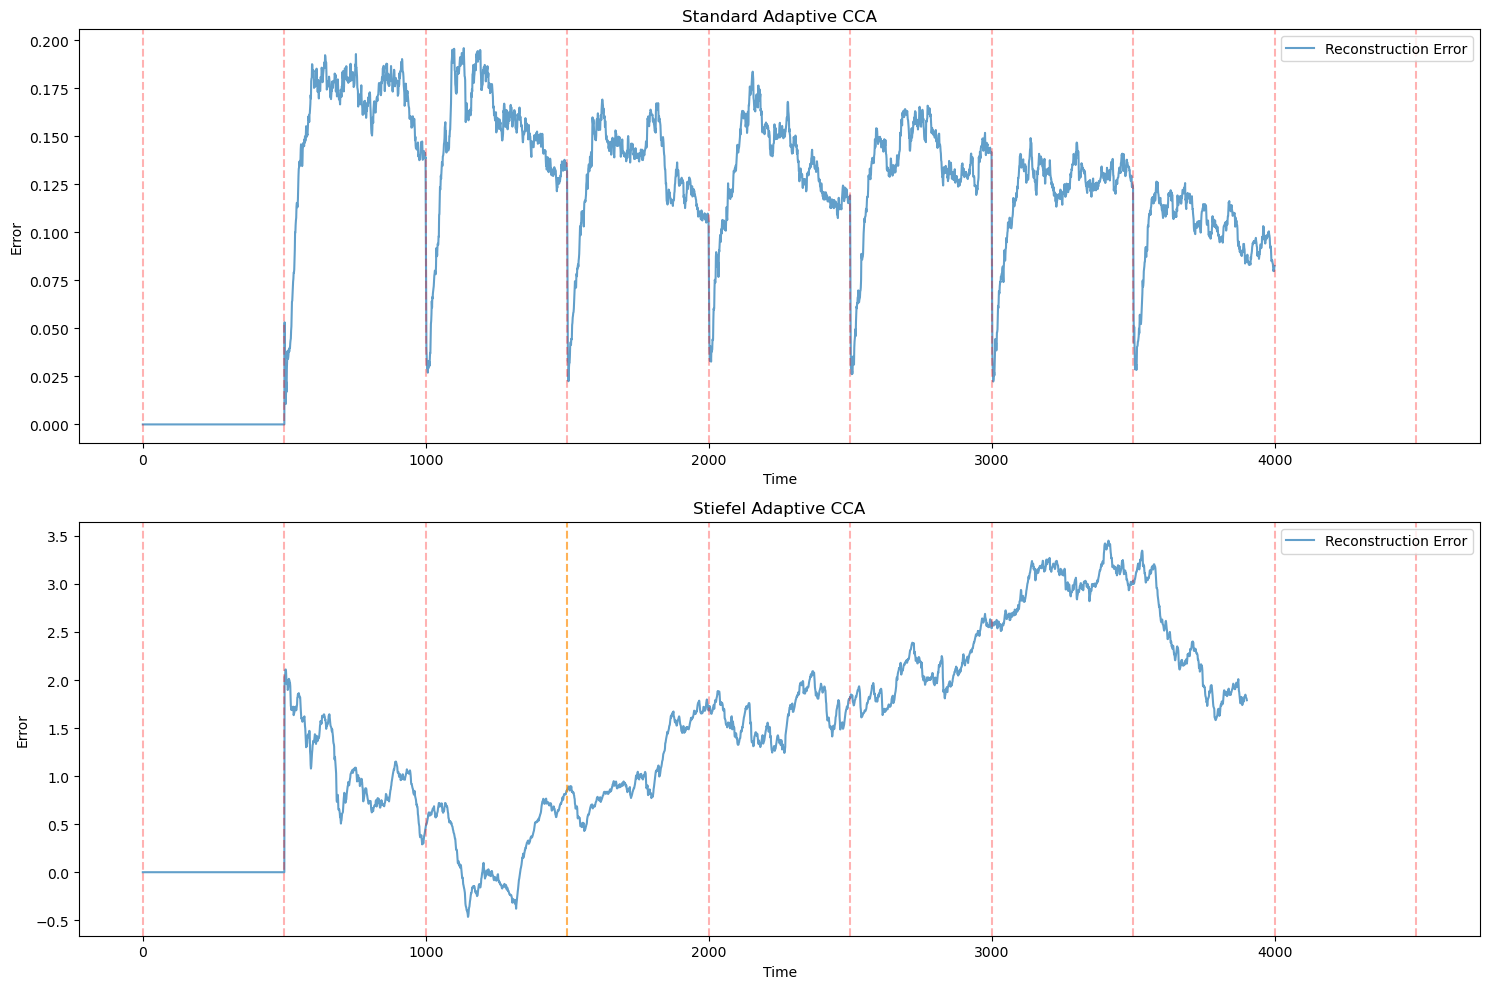

In [40]:
plot_comparison(standard_errors, standard_changes, reconstruction_errors_stiefel, detected_changes_stiefel, true_changes)

In [ ]:
plot_comparison(standard_errors, standard_changes, stiefel_errors, stiefel_changes, true_changes)